<a href="https://colab.research.google.com/github/hirokiyamauch/NLP_100knock/blob/%E7%AC%AC5%E7%AB%A0/40_49.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://nlp100.github.io/data/ai.ja.zip

--2022-02-28 04:29:44--  https://nlp100.github.io/data/ai.ja.zip
Resolving nlp100.github.io (nlp100.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to nlp100.github.io (nlp100.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17516 (17K) [application/zip]
Saving to: ‘ai.ja.zip’

ai.ja.zip           100%[===================>]  17.11K  --.-KB/s    in 0.001s  

2022-02-28 04:29:44 (23.6 MB/s) - ‘ai.ja.zip’ saved [17516/17516]



In [ ]:
!unzip /content/ai.ja.zip

Archive:  /content/ai.ja.zip
  inflating: ai.ja.txt               
  inflating: readme.ai.ja.md         


In [ ]:
# MeCabのインストール
! apt install mecab libmecab-dev mecab-ipadic-utf8
# CRF++のソースファイルのダウンロード・解凍・インストール
FILE_ID = "0B4y35FiV1wh7QVR6VXJ5dWExSTQ"
FILE_NAME = "crfpp.tar.gz"
! wget 'https://docs.google.com/uc?export=download&id=$FILE_ID' -O $FILE_NAME
! tar xvf crfpp.tar.gz
% cd CRF++-0.58
! ./configure && make && make install && ldconfig
% cd ..
# CaboChaのソースファイルのダウンロード・解凍・インストール
FILE_ID = "0B4y35FiV1wh7SDd1Q1dUQkZQaUU"
FILE_NAME = "cabocha-0.69.tar.bz2"
! wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=$FILE_ID' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=$FILE_ID" -O $FILE_NAME && rm -rf /tmp/cookies.txt
! tar -xvf cabocha-0.69.tar.bz2
% cd cabocha-0.69
! ./configure -with-charset=utf-8 && make && make check && make install && ldconfig
% cd ..

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libmecab-dev is already the newest version (0.996-5).
mecab is already the newest version (0.996-5).
mecab-ipadic-utf8 is already the newest version (2.7.0-20070801+main-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
--2022-02-28 04:33:17--  https://docs.google.com/uc?export=download&id=0B4y35FiV1wh7QVR6VXJ5dWExSTQ
Resolving docs.google.com (docs.google.com)... 142.250.141.113, 142.250.141.139, 142.250.141.100, ...
Connecting to docs.google.com (docs.google.com)|142.250.141.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-74-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/75f9hhoj4c2kct0pa1upfud1pidf1hdh/1646022750000/13553212398903315502/*/0B4y35FiV1wh7QVR6VXJ

In [ ]:
def cabocha_makefile(filename, filename_write):
    import CaboCha
    cp = CaboCha.Parser()
    with open(filename) as f:
        fw = open(filename_write, "w")
        for sentence in f:
            tree = cp.parse(sentence)
            fw.write(tree.toString(CaboCha.FORMAT_LATTICE))
        fw.close

In [ ]:
! cabocha -f1 -o ai.ja.txt.parsed ai.ja.txt

In [ ]:
cabocha_makefile('/content/ai.ja.txt','/content/ai.ja.txt.parsed')

ModuleNotFoundError: ignored

**40係り受け解析結果の読み込み（形態素）**

---


 形態素を表すクラスMorphを実装せよ．このクラスは表層形（surface），基本形（base），品詞（pos），品詞細分類1（pos1）をメンバ変数に持つこととする．さらに，係り受け解析の結果（ai.ja.txt.parsed）を読み込み，各文をMorphオブジェクトのリストとして表現し，冒頭の説明文の形態素列を表示せよ．

In [ ]:
class Morph():

    def __init__(self, line):
        import re
        phrase = re.split('\t|,', line)

        self.surface = phrase[0]
        self.base = phrase[7]
        self.pos = phrase[1]
        self.pos1 = phrase[2] 
    #'surface':phrase[0], 'base':phrase[7], 'pos':phrase[1], 'pos1':phrase[2]
    def __str__(self):
        return 'surface[{}]\tbase[{}]\tpos[{}]\tpos1[{}]'.format(self.surface, self.base, self.pos, self.pos1)

def cabocha_dic(filename):

    with open(filename) as f:
        cabo_dic = []
        for sentence in f:
            if not(sentence == 'EOS\n' or sentence.startswith('*')):
                cabo_dic.append(Morph(sentence))

        return cabo_dic


In [ ]:
morpheme_dic = []
morpheme_dic = cabocha_dic('/content/ai.ja.txt.parsed')

print(morpheme_dic[20])

surface[計算]	base[計算]	pos[名詞]	pos1[サ変接続]


41

In [ ]:
class Chunk:
    def __init__(self, sentence):
        self.morphs = []
        self.dst = int(sentence.split(' ')[2].rstrip('D'))
        self.srcs = []

def parse_cabocha(content):
    import re

    line = []
    chunk = None
    #改行ごとの内容で場合分け
    for sentence in content:
        
        #終了
        if sentence == 'EOS\n':
            line_cp = []
            for index, chunk in enumerate(line):
            # 係り先が -1 以外の場合実行
                if chunk.dst != -1:
                     line[chunk.dst].srcs.append(index) 
            line_cp = line
            line = []
            yield line_cp      
        #係り元,係り先
        elif re.match(r'^\*[^\t]+$', sentence):
            #*の形態素を除外する(*の後に\tをついていないもの)
            chunk = Chunk(sentence)
            line.append(chunk)
         
        #2行目
        else:
            chunk.morphs.append(Morph(sentence))

filename = '/content/ai.ja.txt.parsed'
sentences = []
with open(filename) as f: 
  for line in f:
    sentences.append(line)
  #Chunk作成
  chunk_contents = list(parse_cabocha(sentences))

    

In [ ]:
for i, chunk in enumerate(chunk_contents[20]):
        print('* ', i)
        print("srcs", chunk.srcs, "dst", chunk.dst)
        print('|\t'.join([str(m) for m in chunk.morphs]))

*  0
srcs [] dst 1
surface[17]	base[*
]	pos[名詞]	pos1[数]|	surface[世紀]	base[世紀]	pos[名詞]	pos1[一般]
*  1
srcs [0] dst 9
surface[初め]	base[初め]	pos[名詞]	pos1[副詞可能]|	surface[、]	base[、]	pos[記号]	pos1[読点]
*  2
srcs [] dst 9
surface[ルネ・デカルト]	base[*
]	pos[名詞]	pos1[一般]|	surface[は]	base[は]	pos[助詞]	pos1[係助詞]|	surface[、]	base[、]	pos[記号]	pos1[読点]
*  3
srcs [] dst 4
surface[動物]	base[動物]	pos[名詞]	pos1[一般]|	surface[の]	base[の]	pos[助詞]	pos1[連体化]
*  4
srcs [3] dst 8
surface[身体]	base[身体]	pos[名詞]	pos1[一般]|	surface[が]	base[が]	pos[助詞]	pos1[格助詞]
*  5
srcs [] dst 7
surface[ただ]	base[ただ]	pos[名詞]	pos1[一般]|	surface[の]	base[の]	pos[助詞]	pos1[連体化]
*  6
srcs [] dst 7
surface[複雑]	base[複雑]	pos[名詞]	pos1[形容動詞語幹]|	surface[な]	base[だ]	pos[助動詞]	pos1[*]
*  7
srcs [5, 6] dst 8
surface[機械]	base[機械]	pos[名詞]	pos1[一般]|	surface[で]	base[だ]	pos[助動詞]	pos1[*]|	surface[ある]	base[ある]	pos[助動詞]	pos1[*]|	surface[と]	base[と]	pos[助詞]	pos1[格助詞]
*  8
srcs [4, 7] dst 9
surface[提唱]	base[提唱]	pos[名詞]	pos1[サ変接続]|	surface[し]	base[する]	pos[動詞]	pos1[自立]|	surface[た]

42

In [ ]:
class Chunk:
    def __init__(self, sentence):
        self.morphs = []
        self.dst = int(sentence.split(' ')[2].rstrip('D'))
        self.srcs = []
    def __str__(self):
        #posが記号以外を用いる
        return ' '.join([str(morph.surface) for morph in self.morphs if morph.pos != '記号'])

def parse_cabocha(content):
    import re

    line = []
    chunk = None
    #改行ごとの内容で場合分け
    for sentence in content:
        
        #終了
        if sentence == 'EOS\n':
            line_cp = []
            for index, chunk in enumerate(line):
            # 係り先が -1 以外の場合実行
                if chunk.dst != -1:
                     line[chunk.dst].srcs.append(index) 
            line_cp = line
            line = []
            yield line_cp      
        #係り元,係り先
        elif re.match(r'^\*[^\t]+$', sentence):
            #*の形態素を除外する(*の後に\tをついていないもの)
            chunk = Chunk(sentence)
            line.append(chunk)
         
        #2行目
        else:
            chunk.morphs.append(Morph(sentence))


In [ ]:
filename = '/content/ai.ja.txt.parsed'
sentences = []
with open(filename) as f: 
  for line in f:
    sentences.append(line)
  #Chunk作成
  chunk_surface = list(parse_cabocha(sentences))

In [ ]:
for chunks in chunk_surface:
    for chunk in chunks:
      if chunk.dst != -1:
        print( str(chunk), "\t", str(chunks[chunk.dst]))

人工 知能 	 語
じん こうち のう 	 語
AI 	 エーアイ と は
エーアイ と は 	 語
計算 	 という
という 	 道具 を
概念 と 	 道具 を
コンピュータ 	 という
という 	 道具 を
道具 を 	 用い て
用い て 	 研究 する
知能 を 	 研究 する
研究 する 	 計算 機 科学
計算 機 科学 	 の
の 	 一 分野 を
一 分野 を 	 指す
指す 	 語
語 	 研究 分野 と も
言語 の 	 推論
理解 や 	 推論
推論 	 問題 解決 など の
問題 解決 など の 	 知的 行動 を
知的 行動 を 	 代わっ て
人間 に 	 代わっ て
代わっ て 	 行わ せる
コンピューター に 	 行わ せる
行わ せる 	 技術 または
技術 または 	 研究 分野 と も
計算 機 	 コンピュータ による
コンピュータ による 	 情報処理 システム の
知的 な 	 情報処理 システム の
情報処理 システム の 	 実現 に関する
設計 や 	 実現 に関する
実現 に関する 	 研究 分野 と も
研究 分野 と も 	 さ れる
日本 大 百科全書 ( ニッポニカ )』 の 	 解説 で
解説 で 	 述べ て いる
情報 工学 者 通信 工学 者 の 	 佐藤 理 史 は
佐藤 理 史 は 	 述べ て いる
次 の よう に 	 述べ て いる
人間 の 	 知的 能力 を
知的 能力 を 	 実現 する
コンピュータ 上 で 	 実現 する
実現 する 	 技術 ソフトウェア コンピュータ システム
様々 な 	 技術 ソフトウェア コンピュータ システム
技術 ソフトウェア コンピュータ システム 	 ある
応用 例 は 	 ある
自然 言語 処理 	 機械 翻訳 かな漢字 変換 構文 解析 等
機械 翻訳 かな漢字 変換 構文 解析 等 	 専門 家 の
専門 家 の 	 推論 判断 を
推論 判断 を 	 模倣 する
模倣 する 	 エキスパート システム
エキスパート システム 	 画像 認識 等 が
画像 データ を 	 解析 し て
解析 し て 	 検出 抽出 し たり する
特定 の 	 パターン を
パターン を 	 検出 抽出 し たり する
検出 抽出 し たり する 	 

43

In [ ]:
i = 0
#chunkごとに
for chunks in chunk_surface:
    for chunk in chunks:
       #chunk内のposが名詞かつ、chunk.dst内のmorphが動詞である
      if chunk.dst != -1:
       if any([morph.pos == '名詞' for morph in chunk.morphs]) and any([morph.pos == '動詞' for morph in chunks[chunk.dst].morphs]):
           print(chunk, "\t", chunks[chunk.dst])
           i += 1


道具 を 	 用い て
知能 を 	 研究 する
一 分野 を 	 指す
知的 行動 を 	 代わっ て
人間 に 	 代わっ て
コンピューター に 	 行わ せる
研究 分野 と も 	 さ れる
解説 で 	 述べ て いる
佐藤 理 史 は 	 述べ て いる
次 の よう に 	 述べ て いる
知的 能力 を 	 実現 する
コンピュータ 上 で 	 実現 する
技術 ソフトウェア コンピュータ システム 	 ある
応用 例 は 	 ある
推論 判断 を 	 模倣 する
画像 データ を 	 解析 し て
解析 し て 	 検出 抽出 し たり する
パターン を 	 検出 抽出 し たり する
画像 認識 等 が 	 ある
1956 年 に 	 命名 さ れ た
ダート マス 会議 で 	 命名 さ れ た
ジョン マッカーシー により 	 命名 さ れ た
命名 さ れ た 	 使わ れ て いる
現在 で は 	 使わ れ て いる
記号 処理 を 	 用い た
記述 を 	 する
主体 と 	 する
意味あい でも 	 使わ れ て いる
思考 ルーチン も 	 呼ば れる
こと も 	 ある
カウンセラー を 	 模倣 し た
プログラム 	 出さ れる が
人工 無 脳 が 	 出さ れる が
引き合い に 	 出さ れる が
計算 機 に 	 さ せよ う という
役割 を 	 さ せよ う という
エキスパート システム と 	 呼ば れる
実現 は 	 困難 視 さ れ て いる
人間 が 	 持つ
暗黙 に 	 持つ
記述 が 	 なり
問題 と 	 なり
利用 が 	 困難 視 さ れ て いる
困難 視 さ れ て いる 	 ある
アプローチ として は 	 知ら れ て いる が
アプローチ も 	 知ら れ て いる が
差 は 	 ある
記号 的 明示 性 に 	 ある
その後 	 集め た
サポートベクターマシン が 	 集め た
注目 を 	 集め た
経験 を 	 行う
元 に 	 行う
学習 を 	 行う
手法 も 	 ある
宇宙 において 	 実装 する という
言葉 通り 	 実装 する という
知性 を 	 表現 し
機械 的 に 	 表現 し
表現 し 	 実装 する という
登場 により 	 行っ た
流行

44

In [ ]:
!brew install graphviz

/bin/bash: brew: command not found


In [ ]:
!pip install graphviz

In [ ]:
from graphviz import Graph
from graphviz import Digraph

dg = Digraph(format='png')

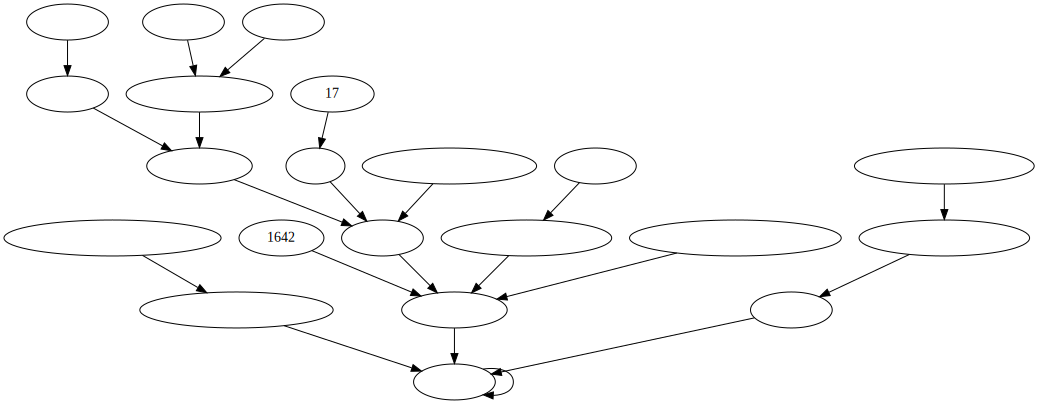

In [ ]:
def make_graph(chunk_sen):
    from graphviz import Digraph

    nodes = []
    #nodeの作成
    for chunk in chunk_sen:
         #かかり先がある場合
         if chunk_sen[chunk.dst] != -1:
          #かかり元
          former = ' '.join([str(morph.surface) for morph in chunk.morphs if morph.pos != '記号'])
          #かかり先
          pre = ' '.join([str(morph.surface) for morph in chunk_sen[chunk.dst].morphs if morph.pos != '記号'])
          nodes.append((former, pre))
    
    #グラフの作成
    graph = Digraph(format="png")
    #ノードごとにグラフに追加
    for node in nodes:
      graph.node(node[0])
      graph.node(node[1])
      graph.edge(node[0], node[1])
    
    return graph
    

chunk_sen = chunk_surface[20]
graph = make_graph(chunk_sen)

graph

        

#nodesの内部
[('17 世紀', '初め'),
 ('初め', '機械 論'),
 ('ルネ・デカルト は', '機械 論'),
 ('動物 の', '身体 が'),
 ('身体 が', '提唱 し た'),
 ('ただ の', '機械 で ある と'),
 ('複雑 な', '機械 で ある と'),
 ('機械 で ある と', '提唱 し た'),
 ('提唱 し た', '機械 論'),
 ('機械 論', '製作 し た'),
 ('ブレーズ・パスカル は', '製作 し た'),
 ('1642 年', '製作 し た'),
 ('最初 の', '機械 式 計算 機 を'),
 ('機械 式 計算 機 を', '製作 し た'),
 ('製作 し た', '行っ た'),
 ('チャールズ バベッジ と', 'エイダ・ラブレス は'),
 ('エイダ・ラブレス は', '行っ た'),
 ('プログラム 可能 な', '機械 式 計算 機 の'),
 ('機械 式 計算 機 の', '開発 を'),
 ('開発 を', '行っ た'),
 ('行っ た', '行っ た')]

45

In [ ]:
#chunkごとに
def case_extract(chunk_surface):
 with open("45ai.txt", "w") as f:
   for chunks in chunk_surface:
     for chunk in chunks:
       #chunk.morphs内のあるposが動詞かつ、そのなかでchunk.srcs内のmorphが助詞である
       for morph in chunk.morphs:
        #動詞
        if ([morph.pos == '動詞' ]):

          case = []
          #助詞
          for sr in chunk.srcs:
               for morph_c in chunks[sr].morphs:
                 if(morph_c.pos == '助詞'):
                   case += [morph_c.base]
          
          #caseが入っていれば保存
          if len(case) > 0:
              #ソートして、重複削除
              case = sorted(list(set(case)))
              #ファイルに保存
              f.write(morph.base + '\t' + ' '.join(case) + '\n')
              
case_extract(chunk_surface)

In [ ]:
!cat 45ai.txt | sort | uniq -c | sort -nr | head

    822 て	を
    289 、	の や
    284 する	を
    182 する	て を
    148 て	て で は
     98 する	て で は
     90 *
     78 	や
     74 ビッグ	の
     65 て	で に の は


In [ ]:
!cat 45ai.txt | grep '行う' | sort | uniq -c | sort -nr

      9 行う	を
      5 行う	て に
      4 行う	て に を
      1 行う	まで を
      1 行う	から
      1 行う	に により を
      1 行う	に まで を
      1 行う	は を をめぐって
      1 行う	が て で に は
      1 行う	が で に は


In [ ]:
!cat 45ai.txt | grep 'なる' | sort | uniq -c | sort -nr

     11 なる	が と
      7 なる	が て と
      7 なる	に
      1 異なる	が で
      1 異なる	も
      1 無くなる	は
      1 なる	から が て で と は
      1 なる	から が て で も
      1 なる	から で と
      1 なる	に によって は
      1 なる	て として に は
      1 なる	が と にとって は
      1 なる	で と など は
      1 なる	が で と に は
      1 なる	が て に は


In [ ]:
!cat 45ai.txt | grep '与える' | sort | uniq -c | sort -nr

      1 与える	が など に
      1 与える	に は を
      1 与える	が に


46

In [ ]:
#chunkごとに
def case_frame_extract(chunk_surface):
 with open("46ai.txt", "w") as f:
   for chunks in chunk_surface:
     for chunk in chunks:
       #chunk.morphs内のあるposが動詞かつ、そのなかでchunk.srcs内のmorphが助詞である
       for morph in chunk.morphs:
        #動詞
        if (morph.pos == '動詞'):

          case = []
          case_se = []
          #助詞
          for sr in chunk.srcs:
               for morph_c in chunks[sr].morphs:
                 if(morph_c.pos == '助詞'):
                   case += [morph_c.base]
                   #係り受け元の文を追加
                   case_se.append(' '.join([str(morph.surface) for morph in chunks[sr].morphs]))
          
          #caseが入っていれば保存
          if len(case) > 0:
              #ソートして、重複削除
              case = sorted(list(set(case)))
              #ファイルに保存
              f.write(morph.base + '\t' + ' '.join(case) + '\t' + ' '.join(case_se) +'\n')
              
case_frame_extract(chunk_surface)

In [ ]:
!cat 46ai.txt |  head

用いる	を	道具 を
する	て を	用い て 『 知能 』 を
指す	を	一 分野 」 を
代わる	に を	知的 行動 を 人間 に
行う	て に	代わっ て コンピューター に
せる	て に	代わっ て コンピューター に
する	と も	研究 分野 」 と も 研究 分野 」 と も
れる	と も	研究 分野 」 と も 研究 分野 」 と も
述べる	で に の は	解説 で 、 佐藤 理 史 は 次 の よう に 次 の よう に
いる	で に の は	解説 で 、 佐藤 理 史 は 次 の よう に 次 の よう に


47

In [ ]:
#chunkごとに
def case_frame_change_extract(chunk_surface):
 with open("47ai.txt", "w") as f:
  for chunks in chunk_surface:
    for chunk in chunks:
       #chunk.morphs内のあるposが動詞かつ、そのなかでchunk.srcs内のmorphが助詞である
      for morph in chunk.morphs:
        #動詞
        if (morph.pos == '動詞'):

          case = []
          case_se = []
          #サ変接続かつ[を]より、morphの数が2つ(エラー回避)
          for i, sr in enumerate(chunk.srcs):
            if len(chunks[sr].morphs)  == 2 and chunks[sr].morphs[0].pos1 == "サ変接続" and chunks[sr].morphs[1].surface == "を":
                
              #構成されている文の抽出
              sentence = (''.join([chunks[sr].morphs[0].surface, chunks[sr].morphs[1].surface, morph.surface]))

              case = []
              cases = []
              case_su = []
              pair = []
               #ほかの助詞を探す(enumerateのiで"サ変接続名詞+を"以外を探す)
              for sr in chunk.srcs[:i]+ chunk.srcs[i + 1:]:
                for morph_c in chunks[sr].morphs:
                  if(morph_c.pos == '助詞'):
                   pair.append([morph_c.base, ''.join([str(morph.surface) for morph in chunks[sr].morphs if morph.pos != '記号'])])

                   
             #ペアが存在すれば、ファイルをソートを行い、書き込み
              if len(pair) > 0:
                    for i in pair:
                      cases.append(i[0])
                      case_su.append(i[1])
                    cases = sorted(list(set(cases)))
                    case_su = sorted(list(set(case_su)), key=lambda x: x[-1])
                    output = sentence + "\t" + ' '.join(cases) + '\t' + ' '.join(case_su) + '\n'
                    f.write(output)
             
case_frame_change_extract(chunk_surface)

In [ ]:
!cat 47ai.txt |  head

記述をする	と	主体と
注目を集め	が	サポートベクターマシンが
経験を行う	に を	元に 学習を
学習を行う	に を	元に 経験を
進化を見せ	て において は	生成技術において 加えて 敵対的生成ネットワークは 活躍している
進化をいる	て において は	生成技術において 加えて 敵対的生成ネットワークは 活躍している
開発を行っ	は	エイダ・ラブレスは
意味をし	に	データに
研究を進める	て	費やして
命令をし	で	機構で


48

In [ ]:
chunks = chunk_surface[20]

for chunk in chunks:
 for morph in chunk.morphs:
     if (morph.pos == '名詞'and chunk.dst != -1):
         path = []
         path.append(''.join([str(morph.surface) for morph in chunk.morphs if morph.pos != '記号']))

         while chunk.dst != -1:
             path.append(''.join([str(morph.surface) for morph in chunks[chunk.dst].morphs if morph.pos != '記号']))
             chunk = chunks[chunk.dst]

         print(' -> '.join(path))

17世紀 -> 初め -> 機械論 -> 製作した -> 行った
初め -> 機械論 -> 製作した -> 行った
ルネ・デカルトは -> 機械論 -> 製作した -> 行った
動物の -> 身体が -> 提唱した -> 機械論 -> 製作した -> 行った
身体が -> 提唱した -> 機械論 -> 製作した -> 行った
ただの -> 機械であると -> 提唱した -> 機械論 -> 製作した -> 行った
複雑な -> 機械であると -> 提唱した -> 機械論 -> 製作した -> 行った
機械であると -> 提唱した -> 機械論 -> 製作した -> 行った
提唱した -> 機械論 -> 製作した -> 行った
機械論 -> 製作した -> 行った
ブレーズ・パスカルは -> 製作した -> 行った
1642年 -> 製作した -> 行った
最初の -> 機械式計算機を -> 製作した -> 行った
機械式計算機を -> 製作した -> 行った
製作した -> 行った
チャールズバベッジと -> エイダ・ラブレスは -> 行った
エイダ・ラブレスは -> 行った
プログラム可能な -> 機械式計算機の -> 開発を -> 行った
機械式計算機の -> 開発を -> 行った
開発を -> 行った


49

In [ ]:
#名詞句をX,Yに変換した物を準備 
def change_noun_xtoy(chunk, noun_x, noun_y):
    for morph in chunk.morphs:
        sentence = ''
        if morph.pos != '記号' and morph.pos != '名詞':
            sentence += str(morph.surface)
    x_sentence = 'X' + sentence
    y_sentence = 'Y' + sentence
    noun_x.append(x_sentence)
    noun_y.append(y_sentence)

    return noun_x, noun_y

chunks = chunk_surface[20]
path_dsts = []
paths = []
noun_x = []
noun_y = []
i = 0
for i, chunk in enumerate(chunks):
 for morph in chunk.morphs:
     if (morph.pos == '名詞'and chunk.dst != -1):
         path = []
         chunk_dst = []
         chunk_dst.append(i+1)
         noun_x, noun_y = change_noun_xtoy(chunk, noun_x, noun_y)
         path.append(''.join([str(morph.surface) for morph in chunk.morphs if morph.pos != '記号']))
         while chunk.dst != -1:
             path.append(''.join([str(morph.surface) for morph in chunks[chunk.dst].morphs if morph.pos != '記号']))
             chunk = chunks[chunk.dst]
             chunk_dst.append(chunk.dst)
         path_dsts.append(chunk_dst)
         paths.append(path)

In [ ]:
i = 0
path_list = []
#保存したpathsについてlen(paths)C2の数調べる
for i in range(len(path_dsts)):
    for j in range(i+1, len(path_dsts)):
        flag = 0
        #path_dsts[i]にpath_dsts[j]のpathが入っている場合、path_dsts[j][0]かそれ以外で判定
        #iで判定
        li_x = (noun_x[i])
        for cnt_x, pa in enumerate(path_dsts[i]):          
            #path_dsts[j][0]で合致
            if pa == path_dsts[j][0]:
                print(li_x, ' -> ', noun_y[j])
                path_list.append([li_x, ' -> ', noun_y[j]])
                flag = 1
            #jが最初以外の場合
            li_y = (noun_y[j])
            for cnt_y, pa_s in enumerate(path_dsts[j][1:]):    
                if cnt_y >= 1:
                    li_y += (' -> ' + paths[j][cnt_y])            
                if pa == pa_s:
                    print(li_x +' | '+ li_y + ' | ' + (' -> '.join(paths[j][cnt_y+1:])))           
                    path_list.append(li_x +' -> '+ li_y + ' -> ' + (' -> '.join(paths[i][cnt_y:])))
                    flag = 1
                    break
                #合致するまでのjの並びを記録

            #合致した物が出た際につぎにうつる
            if flag == 1:
                break
            #合致するまでのiの並びを記録
            if cnt_x >= 1:
                li_x += (' -> ' + paths[i][cnt_x])


X -> 初め | Y | 機械論 -> 製作した -> 行った
X -> 初め | Y | 機械論 -> 製作した -> 行った
X | Yの -> 身体が | 提唱した -> 機械論 -> 製作した -> 行った
X | Yが | 提唱した -> 機械論 -> 製作した -> 行った
X | Yの -> 機械であると | 提唱した -> 機械論 -> 製作した -> 行った
X | Yな -> 機械であると | 提唱した -> 機械論 -> 製作した -> 行った
X | Yと | 提唱した -> 機械論 -> 製作した -> 行った
X  ->  Yた
X -> 初め -> 機械論 | Y | 製作した -> 行った
X -> 初め -> 機械論 | Yは | 製作した -> 行った
X -> 初め -> 機械論 | Y | 製作した -> 行った
X -> 初め | Yの | 機械式計算機を -> 製作した -> 行った
X -> 初め  ->  Yを
X -> 初め -> 機械論 -> 製作した | Y | 行った
X -> 初め -> 機械論 | Yと | エイダ・ラブレスは -> 行った
X -> 初め -> 機械論 -> 製作した | Yは | 行った
X -> 初め -> 機械論 | Yな -> 機械式計算機の | 開発を -> 行った
X -> 初め -> 機械論 | Yの | 開発を -> 行った
X -> 初め -> 機械論  ->  Yを
X | Y | 機械論 -> 製作した -> 行った
X | Yの -> 身体が -> 提唱した | 機械論 -> 製作した -> 行った
X | Yが -> 提唱した | 機械論 -> 製作した -> 行った
X | Yの -> 機械であると -> 提唱した | 機械論 -> 製作した -> 行った
X | Yな -> 機械であると -> 提唱した | 機械論 -> 製作した -> 行った
X | Yと -> 提唱した | 機械論 -> 製作した -> 行った
X | Yた | 機械論 -> 製作した -> 行った
X -> 機械論 | Y | 製作した -> 行った
X -> 機械論 | Yは | 製作した -> 行った
X -> 機械論 | Y | 製作した -> 行った
X | Yの | 機械式計

In [ ]:
! cabocha -f1 -o zyon.txt.parsed zyon.txt

In [ ]:
filename = '/content/zyon.txt.parsed'
sentences = []
with open(filename) as f: 
  for line in f:
    sentences.append(line)
  #Chunk作成
  chunk_surface = list(parse_cabocha(sentences))

In [ ]:
for chunks in chunk_surface:
    for chunk in chunks:
      if chunk.dst != -1:
        print( str(chunk), "\t", str(chunks[chunk.dst]))

ジョン マッカーシー は 	 作り出し た
AI に関する 	 最初 の
最初 の 	 会議 で
会議 で 	 作り出し た
人工 知能 という 	 用語 を
用語 を 	 作り出し た
